In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import lpips
from torchvision import transforms
from dataloaders import Kodak, CLIC, DIV2K
from PIL import Image
import yaml
from pytorch_msssim import ms_ssim
import glob
import matplotlib.pyplot as plt
from prompt_inversion.optim_utils import clip_cosine, read_json
import prompt_inversion.open_clip as open_clip
from argparse import Namespace
import tqdm
import os, glob

device = 'cuda:1'

/home/eric/miniconda3/envs/control2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
args = Namespace()
args.__dict__.update(read_json("prompt_inversion/sample_config.json"))

clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(args.clip_model, pretrained=args.clip_pretrain, device=device)

def distortion_CLIP(x, xhat):
    return 1 - clip_cosine([x], [xhat], clip_model, clip_preprocess, device)

In [4]:
lpips_loss = lpips.LPIPS(net='alex') 

def ntc_preprocess(image):
    # transform = transforms.Compose(
    #         [transforms.Grayscale(), transforms.ToTensor()]
    #     )
    transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )
    image = transform(image)
    return image

def distortion_LPIPS(orig, recon):
    recon = ntc_preprocess(recon)
    orig = ntc_preprocess(orig)

    return lpips_loss(orig.unsqueeze(0), recon.unsqueeze(0)).item()
    # loss += lpips_loss(orig.unsqueeze(0), recon.unsqueeze(0)).item()
    

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/eric/miniconda3/envs/control2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eric/miniconda3/envs/control2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/eric/miniconda3/envs/control2/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [5]:
def ntc_preprocess(image):
    # transform = transforms.Compose(
    #         [transforms.Grayscale(), transforms.ToTensor()]
    #     )
    transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )
    image = transform(image)
    return image

In [19]:
# dm = Kodak(root='/home/Shared/image_datasets/Kodak/', batch_size=1)
dm = CLIC(root='/home/Shared/image_datasets/CLIC_resized/2021', batch_size=1)
# dm = DIV2K(root='/home/Shared/image_datasets/DIV2K_resized', batch_size=1)
dset = dm.test_dset

In [22]:
float(os.path.basename(dirs[0]).split('_')[2][0:5])

0.014

In [22]:
# for HiFiC
# 
dirs = sorted(glob.glob(f'../HiFiC/data/reconstructions/CLIC/ultra3/*.png'))

loss = 0
bpp = 0
for i, im in tqdm.tqdm(enumerate(dset), total=len(dset)):
    # recon = Image.open(f'recon_examples/{exp}/{name}/{i}_recon.png')
    recon = Image.open(dirs[i])
    orig = transforms.functional.to_pil_image(im[0])
    loss += distortion_CLIP(orig, recon)
    # print(orig.size, recon.size)
    # loss += distortion_LPIPS(orig, recon)
    # loss += ms_ssim(orig.unsqueeze(0), recon.unsqueeze(0), 1).item()
    bpp += float(os.path.basename(dirs[i]).split('_')[2][0:5])
    # fpath = glob.glob(f'recon_examples/{exp}/{name}/{i}*.yaml')[0]
    # with open(fpath, 'r') as stream:
    #     f = yaml.safe_load(stream)
    # bpp += f['bpp_total']

print(f'Avg loss={loss/len(dset)}, bpp={bpp/len(dset)}')

100%|██████████| 60/60 [00:05<00:00, 11.20it/s]


Avg loss=tensor([0.3371], device='cuda:1'), bpp=0.011700000000000007


In [8]:
# name = 'DIV2K/q1_ms_ssim'
# exp = 'c2020_lowrate'
name = 'DIV2K_recon'
exp = 'SD_pi+hed_clip_sketch0.5'
loss = 0
bpp = 0
for i, im in tqdm.tqdm(enumerate(dset), total=len(dset)):
    if i == 0:
        continue
    recon = Image.open(f'recon_examples/{exp}/{name}/{i}_recon.png')
    orig = transforms.functional.to_pil_image(im[0])
    loss += distortion_CLIP(orig, recon)
    # loss += distortion_LPIPS(orig, recon)
    # loss += ms_ssim(orig.unsqueeze(0), recon.unsqueeze(0), 1).item()

    fpath = glob.glob(f'recon_examples/{exp}/{name}/{i}*.yaml')[0]
    with open(fpath, 'r') as stream:
        f = yaml.safe_load(stream)
    bpp += f['bpp_total']

print(f'Avg loss={loss/(len(dset)-1)}, bpp={bpp/(len(dset)-1)}')

100%|██████████| 100/100 [00:09<00:00, 10.65it/s]


Avg loss=tensor([0.2443], device='cuda:1'), bpp=0.017231176086336876


In [167]:
print(f'Avg loss={loss/len(dset)}, bpp={bpp/len(dset)}')

Avg loss=0.7224775850772858, bpp=0.002677778953902001


In [ ]:
#Kodak
c2020 = {'bpp':0.01873, 'LPIPS':0.5136, 'FID':330.9881, 'KID':0.1022141, 'CLIP':0.4086}
hific = {'bpp':0.0303, 'LPIPS':0.23749, 'FID':94.04095, 'KID':0.03958839, 'CLIP':0.169}
pic = {'bpp':0.00282, 'LPIPS':0.7847, 'FID':246.3423, 'KID':0.01705737, 'CLIP':0.2596}
pics = {'bpp':0.01509, 'LPIPS':0.62328, 'FID':266.8264, 'KID':0.03413666, 'CLIP':0.2120}

In [23]:
#CLIC
c2020 = {'bpp':0.01873, 'LPIPS':0.5136, 'FID':330.9881, 'KID':0.1022141, 'CLIP':0.4086}
hific = {'bpp':[0.012, 0.018], 'LPIPS':[0.304, 0.2521], 'FID':[281.5183, 276.309], 'KID':[0.04647485, 0.03958839], 'CLIP':[0.3371, 0.2431]}
pic = {'bpp':0.00282, 'LPIPS':0.7847, 'FID':246.3423, 'KID':0.01705737, 'CLIP':0.2596}
pics = {'bpp':0.01509, 'LPIPS':0.62328, 'FID':266.8264, 'KID':0.03413666, 'CLIP':0.2120}

In [11]:
#DIV2K
c2020 = {'bpp':0.0217, 'LPIPS':0.6182, 'FID':265.1075, 'KID':0.08099189, 'CLIP':0.4330}
hific = {'bpp':[0.01426, 0.02285], 'LPIPS':[0.3383, 0.2826], 'FID':[205.8427, 191.756], 'KID':[0.02133513, 0.009482518], 'CLIP':[0.3157, 0.2365]}
pic = {'bpp':0.0027, 'LPIPS':0.7224, 'FID':173.4034, 'KID':0.002233582, 'CLIP':0.2736}
pics = {'bpp':0.0172, 'LPIPS':0.67, 'FID':182.0725, 'KID':0.0025435, 'CLIP':0.2443}

In [13]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams.update({'font.size': 28})
plt.rcParams.update({'lines.linewidth':4})
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = None
plt.rcParams['legend.edgecolor'] = 'inherit'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
# plt.rcParams['font.family'] = 'serif'
plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["markersize"]

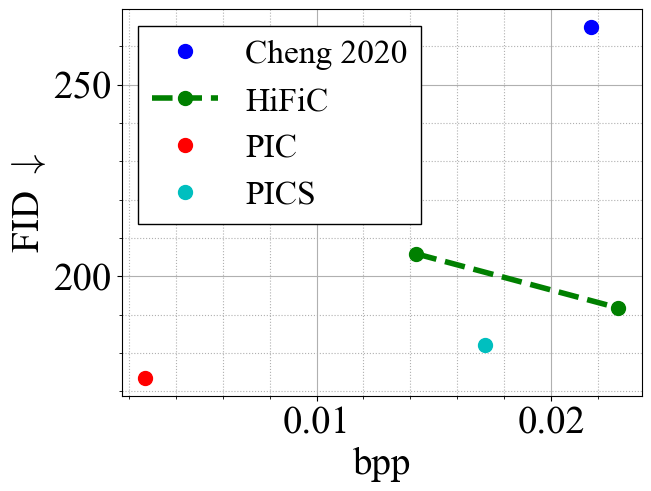

In [16]:
key = 'FID'
plt.figure(constrained_layout=True)
plt.plot(c2020['bpp'], c2020['FID'], 'o', markersize=10, label='Cheng 2020')
plt.plot(hific['bpp'], hific['FID'], '--o',markersize=10, label='HiFiC')
plt.plot(pic['bpp'], pic['FID'], 'o', markersize=10,label='PIC')
plt.plot(pics['bpp'], pics['FID'], 'o', markersize=10,label='PICS')

plt.legend(fontsize=24)
# plt.legend()
plt.ylabel(r'FID $\downarrow$')
plt.xlabel('bpp')
plt.grid(which='major', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
# plt.savefig(f'plots/{key}_DIV2K.pdf')

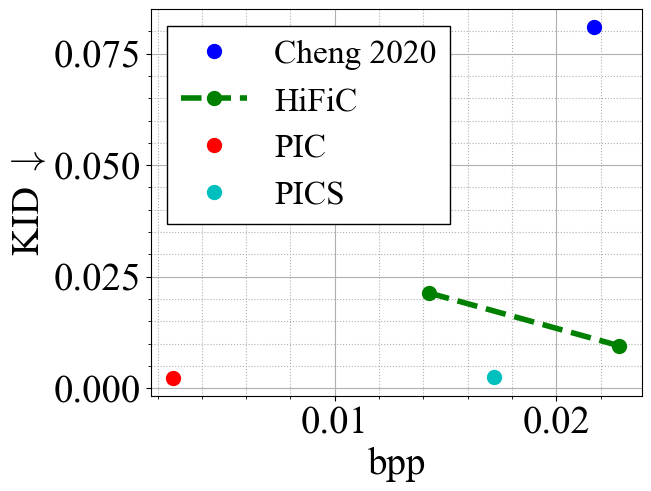

In [17]:
key = 'KID'
plt.figure(constrained_layout=True)
plt.plot(c2020['bpp'], c2020[key], 'o',markersize=10, label='Cheng 2020')
plt.plot(hific['bpp'], hific[key], '--o', markersize=10,label='HiFiC')
plt.plot(pic['bpp'], pic[key], 'o', markersize=10,label='PIC')
plt.plot(pics['bpp'], pics[key], 'o',markersize=10, label='PICS')
plt.legend(fontsize=24)
# plt.legend()
plt.ylabel(rf'{key} $\downarrow$')
plt.xlabel('bpp')
plt.grid(which='major', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
# plt.savefig(f'plots/{key}_DIV2K.pdf')

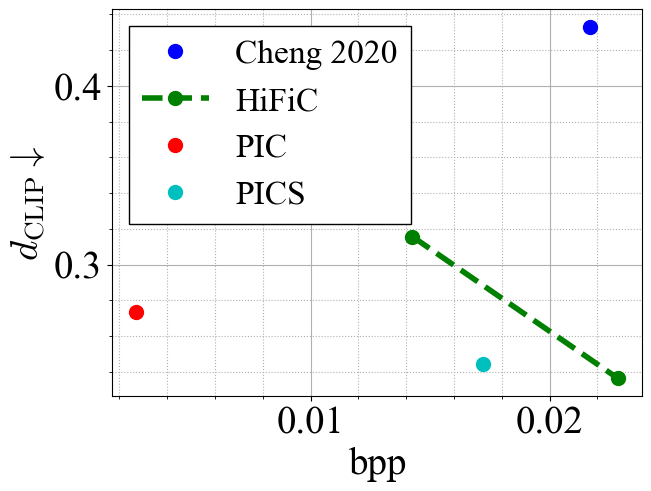

In [18]:
key = 'CLIP'
plt.figure(constrained_layout=True)
plt.plot(c2020['bpp'], c2020[key], 'o',markersize=10, label='Cheng 2020')
plt.plot(hific['bpp'], hific[key], '--o', markersize=10,label='HiFiC')
plt.plot(pic['bpp'], pic[key], 'o', markersize=10,label='PIC')
plt.plot(pics['bpp'], pics[key], 'o',markersize=10, label='PICS')

plt.legend(fontsize=24)
# plt.legend()
plt.ylabel(r'$d_{\mathrm{CLIP}} \downarrow$')
plt.xlabel('bpp')
plt.grid(which='major', linestyle='-')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
# plt.savefig(f'plots/{key}_DIV2K.pdf')

In [ ]:

# CLIC
# c2020/q1_ms-ssim: bpp=0.01873, LPIPS=0.5136, FID=330.9881, KID=0.1022141, CLIP=0.4086
# HiFiC: bpp=0.018, LPIPS=0.2521, FID=276.309, KID=0.03958839, CLIP=0.2431
# SD_pi_clip: bpp=0.00282, LPIPS=0.7847, FID=246.3423, KID=0.01705737, CLIP=0.2596
# SD_pi+hed_clip_rcc: bpp=0.01509, LPIPS=0.62328, FID=266.8264, KID=0.03413666, CLIP=0.2120

# DIV2K
# q1_ms-ssim: bpp=0.0217, LPIPS=0.6182, FID=265.1075, KID=0.08099189, CLIP=0.4330
# HiFiC: bpp=0.02285, LPIPS=0.2826, FID=191.756, KID=0.009482518, CLIP=0.2365
# SD_pi: bpp=0., LPIPS=0., FID=, KID=0., CLIP=0.
# SD_pi+hed_lpips_rcc: bpp=0., LPIPS=0., FID=, KID=0., CLIP=0.


In [ ]:
c2020 = {'bpp:0.01873, LPIPS=0.5136, FID=330.9881, KID=0.1022141, CLIP=0.4086}

In [28]:
import yaml

In [30]:
with open(f'recon_examples/SD_pi+hed_lpips_sketch0.5/DIV2K_recon/{i}_caption.yaml', 'r') as file:
    caption_dict = yaml.safe_load(file)

In [31]:
caption_dict

{'bpp_caption': 0.003506747159090909,
 'bpp_sketch': 0.01626032049005682,
 'bpp_total': 0.019767067649147728,
 'caption': '💪💪💪 montana chaotic nwsl disabilities bachelorette bootcamp retreat participants uphill backpacking �▂�anced ultimatefangog drainage ',
 'hyper_strings': b'\x91S;\xd6\x01\x00\x00\x00',
 'prior_strings': b'\x1a\x8a\xa3@\xfd~\x01\x00\xdf\xd6\xf8\x98\xf4\x81V\xae\xbd\xbf\xed\xce"\x9a\xe2y\x03\xff\n\r\x1d\x85WV\x17Yy}W\x14\xecl\x12FD\xb9Z\xf4HM\x1ci\x12\xa1C\xa94\x87q\x8a\x08t\x9a\xa8{\x81\x7f\x8a\xa7T\xe9\x82g@\xdc\xd5EBk\xbb\x1eko\xc2\xafk\xd0\xc56o\xde\t?\x12\xe2\x17\'\xa11\xf5`m\xc8\xd2\x1e\xe3k\x7f\xad\x83\xc9\xa4\xb6\x00\x96\x0f\x03\xbc\x8c\x0f\xee\x05\xa6&\xdd\x19h\x80\x9f\xc0\x93\'\xf9\x0f|\xe8\x96\x9d\xd6w\x05\x0f"\xcbU0\x07\x91\xebk\xc7\x92\x07\xb9[p\x92\xd5JP\x13\x0c\rw\xcb\xb35\x97\x19\xf4\xe0]\x83%\xee\xb8\xe1$\xdc\t\xedA\xbd\x81\xcf-\xe1\x88\xe3\xaa\x80@c)\xbf\xc1\x0e\xd7\xf4\x1f\xd6L\x99>L\xa5YD\x84i\x82\'\x051\xc5\x93\x01\xdf\x90\xb9#s\xe9\x9d\x9f\xcd\x

In [32]:
caption_dict['caption']

'💪💪💪 montana chaotic nwsl disabilities bachelorette bootcamp retreat participants uphill backpacking �▂�anced ultimatefangog drainage '

In [33]:
i = 0

In [42]:
with open(f'recon_examples/SD_pi+hed_lpips_sketch0.5/DIV2K_recon/1_caption.yaml', 'r') as file:
    caption_dict = yaml.safe_load(file)

In [43]:
caption_dict['caption']

'loki citrus mexican grapes dumping xy ril carlyle shares shares dow ultimatefanultimatefanultimatefanintraequities '

In [41]:
caption_dict